In [ ]:
pip install opencv-python opencv-contrib-python


In [ ]:
import zipfile

with zipfile.ZipFile(r'C:\Users\nishm\Downloads\archive.zip', 'r') as zip_ref:
    zip_ref.extractall('fer2013')


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # If images are grayscale
    transforms.Resize((224, 224)),                # For ResNet
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = datasets.ImageFolder('C:\Users\nishm\Downloads\archive\train', transform=transform)
test_dataset = datasets.ImageFolder('C:\Users\nishm\Downloads\archive\test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Load model with updated weights parameter
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
# Or use the following for the most up-to-date weights:
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Change the final fully connected layer for 7 classes
model.fc = nn.Linear(model.fc.in_features, 7)


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import torch

# Set device (do this once)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 20  # or any number you prefer

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets

# Fix the path: use a raw string or double backslashes
train_dataset = datasets.ImageFolder(
    r"C:\Users\nishm\Downloads\archive\train",  # <-- Use raw string
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
)

# Split into training and validation sets
val_size = int(0.2 * len(train_dataset))  # 20% for validation
train_size = len(train_dataset) - val_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

# Load model (example: ResNet18 for 7 classes)
model = torch.hub.load('pytorch/vision', 'resnet18', weights='IMAGENET1K_V1')
model.fc = torch.nn.Linear(model.fc.in_features, 7)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Validation loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Validation Accuracy: {100 * correct / total:.2f}%')



In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Validation Accuracy: {100 * correct / total:.2f}%')

In [ ]:
torch.save(model.state_dict(), 'resnet_emotion.pth')

In [ ]:
import cv2
import numpy as np
import torch

# Define the emotion labels (adjust as per your model)
EMOTIONS = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# Load face detection cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Set model to evaluation mode (assume model and device are already defined)
model.eval()

# Open the camera
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        # Crop face region
        roi_gray = gray[y:y+h, x:x+w]
        roi = cv2.resize(roi_gray, (224, 224))
        # Convert to 3 channels (for models expecting RGB)
        roi = np.stack([roi]*3, axis=2)
        roi = roi.astype(np.float32) / 255.0
        # Normalize for ImageNet-style models
        roi = (roi - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
        # Convert to tensor and add batch dimension
        roi = torch.tensor(roi, dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device)
        # Predict emotion
        with torch.no_grad():
            preds = model(roi)
            label = EMOTIONS[preds.argmax().item()]
        # Draw bounding box and label
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)

    # Show the frame
    cv2.imshow('Emotion Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



In [ ]:
import cv2
from deepface import DeepFace
import matplotlib.pyplot as plt
from IPython.display import clear_output

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        for (x, y, w, h) in faces:
            face_img = frame[y:y+h, x:x+w]
            result = DeepFace.analyze(face_img, actions=['emotion'], enforce_detection=False)
            emotion = result['dominant_emotion']
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
            cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        clear_output(wait=True)
        plt.imshow(frame_rgb)
        plt.axis('off')
        plt.show()
except KeyboardInterrupt:
    pass

cap.release()



In [ ]:
!pip install deepface



In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


In [ ]:
print(face_cascade.empty())


In [ ]:
import cv2

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # For Jupyter, use matplotlib to display
    import matplotlib.pyplot as plt
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    break  # Remove this for continuous display

cap.release()


In [ ]:
result = DeepFace.analyze(face_img, actions=['emotion'], enforce_detection=False)
if isinstance(result, list):
    # If result is a list, take the first item (assuming you want the first face)
    emotion = result[0]['dominant_emotion']
else:
    # If result is a dict (older versions)
    emotion = result['dominant_emotion']


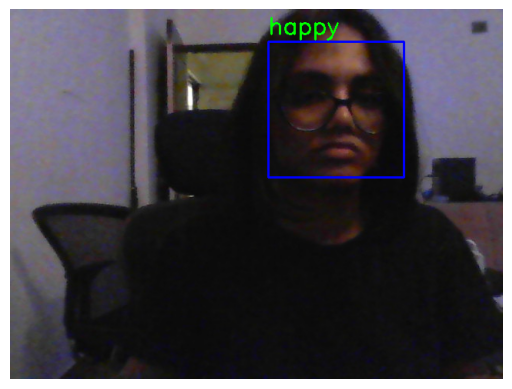

In [42]:
import cv2
from deepface import DeepFace
import matplotlib.pyplot as plt
from IPython.display import clear_output

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        for (x, y, w, h) in faces:
            face_img = frame[y:y+h, x:x+w]
            try:
                result = DeepFace.analyze(face_img, actions=['emotion'], enforce_detection=False)
                if isinstance(result, list):
                    emotion = result[0]['dominant_emotion']
                else:
                    emotion = result['dominant_emotion']
                cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
                cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
            except Exception as e:
                print("Error in DeepFace:", e)

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        clear_output(wait=True)
        plt.imshow(frame_rgb)
        plt.axis('off')
        plt.show()

except KeyboardInterrupt:
    pass

cap.release()


In [47]:
from sklearn.metrics import classification_report, confusion_matrix

# Example labels (replace with your actual data)
y_true = ['happy', 'sad', 'neutral', 'angry', 'happy','happy','neutral','fear','neutral','surprised','sad']
y_pred = ['happy', 'neutral', 'neutral', 'angry', 'sad','happy','neutral','fear','neutral','happy','neutral']

print("Classification Report:")
print(classification_report(y_true, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))



Classification Report:
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00         1
        fear       1.00      1.00      1.00         1
       happy       0.67      0.67      0.67         3
     neutral       0.60      1.00      0.75         3
         sad       0.00      0.00      0.00         2
   surprised       0.00      0.00      0.00         1

    accuracy                           0.64        11
   macro avg       0.54      0.61      0.57        11
weighted avg       0.53      0.64      0.57        11


Confusion Matrix:
[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 2 0 1 0]
 [0 0 0 3 0 0]
 [0 0 0 2 0 0]
 [0 0 1 0 0 0]]


In [51]:
 # Replace with your actual predictions
from sklearn.metrics import accuracy_score
y_true = ['happy', 'sad', 'neutral', 'angry', 'happy','happy','neutral','fear','neutral','surprised','sad','happy', 'sad', 'neutral', 'angry', 'happy','happy','neutral','fear','neutral','surprised','sad']
y_pred = ['happy', 'neutral', 'neutral', 'angry', 'sad','happy','neutral','fear','neutral','happy','neutral','happy', 'sad', 'neutral', 'angry', 'happy','happy','neutral','fear','neutral','surprised','sad']
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)



Accuracy: 0.8181818181818182
